In [52]:
import os
import json
import openslide

import numpy as np
from PySlide.annotations import Annotations
from itertools import chain
import matplotlib.pyplot as plt

In [53]:
path = 'images/14.90610 C L2.11.json'
labels = {'GC':0}
file_type = 'json'
keys = ['GC']

In [54]:
ann=Annotations(labels, path, file_type, keys)

In [55]:
f = ann.generate_annotations(keys)

{'GC': {'1': [{'x': 12949.7841796875, 'y': 16619.09765625}, {'x': 12949.7841796875, 'y': 16619.09765625}, {'x': 12949.7841796875, 'y': 16608.841796875}, {'x': 12960.041015625, 'y': 16608.841796875}, {'x': 13011.3232421875, 'y': 16608.841796875}, {'x': 13031.8359375, 'y': 16608.841796875}, {'x': 13175.4267578125, 'y': 16578.072265625}, {'x': 13195.9404296875, 'y': 16578.072265625}, {'x': 13236.9658203125, 'y': 16567.814453125}, {'x': 13247.22265625, 'y': 16567.814453125}, {'x': 13298.5048828125, 'y': 16557.55859375}, {'x': 13319.017578125, 'y': 16557.55859375}, {'x': 13349.787109375, 'y': 16547.302734375}, {'x': 13370.30078125, 'y': 16547.302734375}, {'x': 13421.5830078125, 'y': 16547.302734375}, {'x': 13431.83984375, 'y': 16537.044921875}, {'x': 13472.865234375, 'y': 16526.7890625}, {'x': 13483.1220703125, 'y': 16526.7890625}, {'x': 13493.37890625, 'y': 16526.7890625}, {'x': 13554.9169921875, 'y': 16516.533203125}, {'x': 13575.4306640625, 'y': 16506.275390625}, {'x': 13616.4560546875, 

In [56]:
f

{'GC': {'1': [{'x': 12949.7841796875, 'y': 16619.09765625},
   {'x': 12949.7841796875, 'y': 16619.09765625},
   {'x': 12949.7841796875, 'y': 16608.841796875},
   {'x': 12960.041015625, 'y': 16608.841796875},
   {'x': 13011.3232421875, 'y': 16608.841796875},
   {'x': 13031.8359375, 'y': 16608.841796875},
   {'x': 13175.4267578125, 'y': 16578.072265625},
   {'x': 13195.9404296875, 'y': 16578.072265625},
   {'x': 13236.9658203125, 'y': 16567.814453125},
   {'x': 13247.22265625, 'y': 16567.814453125},
   {'x': 13298.5048828125, 'y': 16557.55859375},
   {'x': 13319.017578125, 'y': 16557.55859375},
   {'x': 13349.787109375, 'y': 16547.302734375},
   {'x': 13370.30078125, 'y': 16547.302734375},
   {'x': 13421.5830078125, 'y': 16547.302734375},
   {'x': 13431.83984375, 'y': 16537.044921875},
   {'x': 13472.865234375, 'y': 16526.7890625},
   {'x': 13483.1220703125, 'y': 16526.7890625},
   {'x': 13493.37890625, 'y': 16526.7890625},
   {'x': 13554.9169921875, 'y': 16516.533203125},
   {'x': 13575

In [30]:
slide = patch.Slide('14.90610 C L2.11.ndpi', annotations, border='draw')

NameError: name 'patch' is not defined

In [7]:
x = slide.slide_mask((2000,2000))

In [10]:
region, mask = slide.generate_region(mag=4, scale_border=True, factor=256)

x_size:1024
y_size:1024


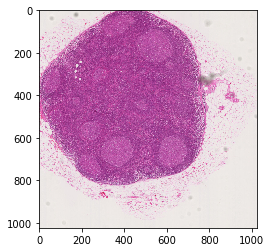

In [11]:
plt.imshow(region)